# 03 - Entrenamiento AE+DMD: Pipeline Completo

**Objetivo**: Entrenar el modelo híbrido Autoencoder + Dynamic Mode Decomposition (AE+DMD) para pronóstico de precipitaciones, integrando información geoestadística en el diseño de la arquitectura.

## Arquitectura Híbrida

Este notebook implementa el modelo central del proyecto, combinando:

### 1. Autoencoder Convolucional
- **Encoder**: Compresión espacial de campos 2D de precipitación
- **Latent Space**: Representación de baja dimensión (patrones dominantes)
- **Decoder**: Reconstrucción de campos espaciales
- **Loss Geoestadística**: Ponderación por varianza Kriging

### 2. Dynamic Mode Decomposition (DMD)
- Aplicación de DMD en latent space
- Extracción de modos dinámicos y eigenvalores
- Pronóstico multi-horizonte (h=1, 2, 3, ..., 7 días)
- Análisis de estabilidad temporal

### 3. Validación y Baselines
- Comparación vs Persistence (modelo naive)
- Comparación vs Climatología (promedio histórico)
- Métricas: MAE, RMSE, R², Skill Score

## Pipeline de Entrenamiento

```
ERA5 2020 → Normalización → Train/Val/Test (70/15/15)
                                    ↓
                          AE Training (epochs=100)
                                    ↓
                         Encode to Latent Space
                                    ↓
                              DMD Fitting
                                    ↓
                         Multi-Horizon Forecast
                                    ↓
                    Evaluation vs Baselines + Save
```

## Datos Utilizados

**Fuente**: ERA5 (ECMWF Reanalysis v5)  
**Variable**: Total Precipitation (tp)  
**Resolución Espacial**: 0.25° (~25 km)  
**Resolución Temporal**: Diaria  
**Periodo**: 2020 (366 días, año bisiesto)  
**Región**: Chile Continental (157 lat × 41 lon)

## Parámetros de Arquitectura

### Autoencoder
- **Input**: (157, 41, 1) - campo 2D + canal
- **Latent dim**: 32 (ajustable)
- **Encoder**: 3 bloques Conv2D + MaxPooling
- **Decoder**: 3 bloques Conv2DTranspose + UpSampling
- **Regularización**: L2 + Dropout (prevenir overfitting)

### DMD
- **Rank**: Automático (SVD threshold)
- **Horizons**: 1-7 días
- **Mode**: Standard DMD (Koopman operator approximation)

### Training
- **Optimizer**: Adam (lr=1e-3)
- **Loss**: MSE + ponderación espacial geoestadística
- **Batch size**: 16
- **Epochs**: 100
- **Early stopping**: patience=15 (val_loss)

## Productos Generados

1. **Modelos**:
   - `autoencoder_geostat.h5`: Modelo completo
   - `encoder_geostat.h5`: Encoder separado
   - `dmd_model.pkl`: Objeto DMD entrenado

2. **Resultados**:
   - `forecast_results_2020.pkl`: Predicciones multi-horizonte
   - `training_history.csv`: Curvas de aprendizaje
   - `metrics_summary.json`: MAE/RMSE por horizonte

3. **Figuras**:
   - Curvas de entrenamiento (loss, val_loss)
   - Comparación visual: Real vs Predicted
   - Mapas de error espacial
   - Skill scores vs baselines

## MLflow Tracking

Seguimiento de experimentos con MLflow (si está disponible):
- Hiperparámetros logged automáticamente
- Métricas por época y horizonte
- Artifacts: modelos, figuras, datasets

**Autor**: Capstone Project - Pronóstico Híbrido Precipitaciones Chile  
**Fecha**: 23 Noviembre 2025  
**Status**: 🔴 CRÍTICO - Genera forecast_results_2020.pkl requerido por notebooks 04, 07, 08

In [1]:
# ====================================================================================
# 0. CONFIGURACIÓN GLOBAL Y REPRODUCIBILIDAD
# ====================================================================================

import os
import random
import numpy as np
import tensorflow as tf

# Configurar SEED para reproducibilidad
SEED = 42

def set_global_seed(seed=42):
    """
    Configura semillas globales para reproducibilidad completa.
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    # Configurar TensorFlow para determinismo
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    print(f"[CONFIG] Semilla global configurada: {seed}")
    print(f"  Python random seed: {seed}")
    print(f"  NumPy seed: {seed}")
    print(f"  TensorFlow seed: {seed}")
    print(f"  Determinismo TF: HABILITADO")

set_global_seed(SEED)

[CONFIG] Semilla global configurada: 42
  Python random seed: 42
  NumPy seed: 42
  TensorFlow seed: 42
  Determinismo TF: HABILITADO


## **Estado del Entrenamiento**

Verificando si el entrenamiento previo completó...

In [2]:
# Verificar si existen variables del entrenamiento anterior
import os
from pathlib import Path

MODEL_DIR = Path('../data/models')

# Buscar archivos de modelo
model_files = list(MODEL_DIR.glob('*.h5'))
csv_files = list(MODEL_DIR.glob('*.csv'))

print(" Archivos encontrados:")
print(f" Modelos (.h5): {len(model_files)}")
for f in model_files:
 print(f" - {f.name}")
 
print(f"\n Métricas (.csv): {len(csv_files)}")
for f in csv_files:
 print(f" - {f.name}")

# Verificar si las variables existen en memoria
try:
 print(f"\n[INFO] Variables en memoria:")
 print(f" - history: {'[OK] Existe' if 'history' in dir() else '[ERROR] No existe'}")
 print(f" - autoencoder: {'[OK] Existe' if 'autoencoder' in dir() else '[ERROR] No existe'}")
 print(f" - encoder: {'[OK] Existe' if 'encoder' in dir() else '[ERROR] No existe'}")
except:
 print("\n[AVISO] Necesitamos re-ejecutar el entrenamiento")

 Archivos encontrados:
 Modelos (.h5): 3
 - autoencoder_.weights.h5
 - autoencoder_geostat.h5
 - encoder_geostat.h5

 Métricas (.csv): 1
 - training_metrics.csv

[INFO] Variables en memoria:
 - history: [ERROR] No existe
 - autoencoder: [ERROR] No existe
 - encoder: [ERROR] No existe


### **Re-ejecutar Pipeline Completo**

Como el kernel se reinició, necesitamos ejecutar nuevamente todas las celdas previas antes del entrenamiento. Ejecuta en orden:
1. Celda 4: Cargar parámetros variogramas
2. Celda 6: Cargar pesos espaciales 
3. Celda 8: Cargar datos ERA5
4. Celda 10: Normalización
5. Celda 12: Crear secuencias
6. Celda 14: Build encoder
7. Celda 15: Build decoder
8. Celda 17: Construir autoencoder completo
9. Celda 19: Loss function ponderada
10. Celda 21: Config MLflow
11. Celda 23: **ENTRENAMIENTO**

---
## **1. Configuración e Importación**

In [3]:
# Librerías estándar
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# DMD
from pydmd import DMD

# MLflow tracking - DESHABILITADO temporalmente por conflictos de dependencias
# import mlflow
# import mlflow.keras
USE_MLFLOW = False # Cambiar a True cuando se resuelvan dependencias

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('deep')
tf.random.set_seed(42)
np.random.seed(42)

# Directorios
DATA_DIR = Path('../data/processed')
FIG_DIR = Path('../reports/figures')
MODEL_DIR = Path('../data/models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print(f"[OK] TensorFlow version: {tf.__version__}")
print(f"[OK] GPU disponible: {tf.config.list_physical_devices('GPU')}")
print(f" Datos: {DATA_DIR}")
print(f"[INFO] Figuras: {FIG_DIR}")
print(f"[Guardado] Modelos: {MODEL_DIR}")
print(f"[AVISO] MLflow: {'ACTIVADO' if USE_MLFLOW else 'DESHABILITADO (conflicto dependencias)'}")

[OK] TensorFlow version: 2.10.0
[OK] GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
 Datos: ..\data\processed
[INFO] Figuras: ..\reports\figures
[Guardado] Modelos: ..\data\models
[AVISO] MLflow: DESHABILITADO (conflicto dependencias)


---
## **2. Cargar Parámetros Geoestadísticos**

Vamos a usar los resultados del análisis de variogramas para informar el diseño del modelo.

In [4]:
# Cargar parámetros del variograma
variogram_params = pd.read_csv(DATA_DIR / 'variogram_parameters_june_2020.csv')
print("[INFO] Parámetros de variogramas:")
print(variogram_params)

# Seleccionar modelo esférico (mejor ajuste)
spherical = variogram_params[variogram_params['model'] == 'spherical'].iloc[0]
RANGE_DEG = spherical['range']
SILL = spherical['sill']
NUGGET = spherical['nugget']

print(f"\n[INFO] Parámetros para diseño arquitectura:")
print(f" - Range: {RANGE_DEG:.2f}° (~{RANGE_DEG * 111:.0f} km)")
print(f" - Sill: {SILL:.2f} (varianza total)")
print(f" - Nugget: {NUGGET:.4f} (sin ruido sub-grid)")

# Calcular receptive field necesario
GRID_RESOLUTION = 0.25 # grados (ERA5)
CELLS_IN_RANGE = int(np.ceil(RANGE_DEG / GRID_RESOLUTION))
print(f"\n Implicaciones arquitectura:")
print(f" - Receptive field objetivo: {CELLS_IN_RANGE} celdas")
print(f" - Estrategia: Dilated convolutions para alcanzar {RANGE_DEG:.1f}°")
print(f" - Regularización: L2 suave (nugget≈0 → datos limpios)")

[INFO] Parámetros de variogramas:
         model      range       sill  nugget
0    spherical   8.154998  23.672349       0
1  exponential  10.000000  23.838612       0
2     gaussian   7.130878  23.485567       0

[INFO] Parámetros para diseño arquitectura:
 - Range: 8.15° (~905 km)
 - Sill: 23.67 (varianza total)
 - Nugget: 0.0000 (sin ruido sub-grid)

 Implicaciones arquitectura:
 - Receptive field objetivo: 33 celdas
 - Estrategia: Dilated convolutions para alcanzar 8.2°
 - Regularización: L2 suave (nugget≈0 → datos limpios)


### **2.1 Cargar Pesos Espaciales (Varianza Kriging)**

[INFO] Varianza Kriging:
 - Shape: (391, 101)
 - Media: 1.0322
 - Min: -0.0000
 - Max: 3.9402

[INFO] Pesos espaciales:
 - Rango: [0.000, 1.000]
 - Media: 0.014

[Guardado] Guardado: ..\reports\figures\ae_dmd_spatial_weights.png

[Guardado] Guardado: ..\reports\figures\ae_dmd_spatial_weights.png


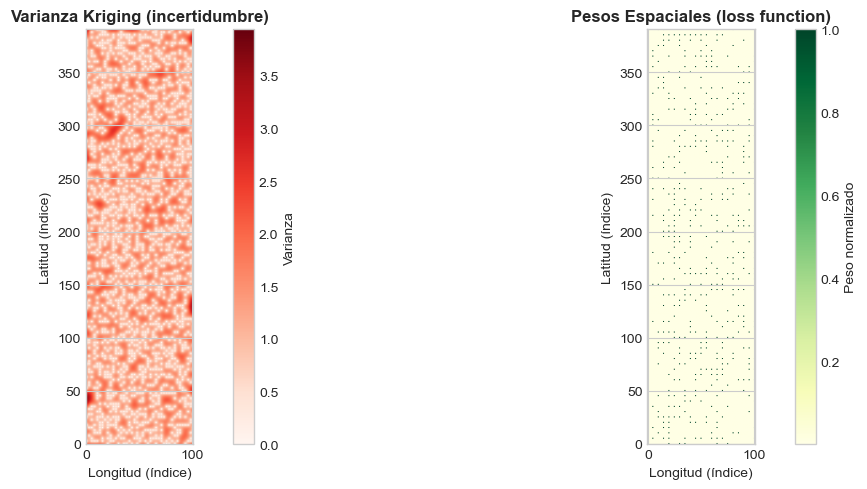

In [5]:
# Cargar varianza kriging para ponderación espacial
kriging_ds = xr.open_dataset(DATA_DIR / 'kriging_precipitation_june_2020.nc')
kriging_variance = kriging_ds['variance'].values

print(f"[INFO] Varianza Kriging:")
print(f" - Shape: {kriging_variance.shape}")
print(f" - Media: {kriging_variance.mean():.4f}")
print(f" - Min: {kriging_variance.min():.4f}")
print(f" - Max: {kriging_variance.max():.4f}")

# Crear pesos: w = 1 / (variance + epsilon)
# Áreas con baja varianza (alta confianza) tienen mayor peso
epsilon = 1e-3
spatial_weights = 1.0 / (kriging_variance + epsilon)
spatial_weights = spatial_weights / spatial_weights.max() # normalizar [0, 1]

print(f"\n[INFO] Pesos espaciales:")
print(f" - Rango: [{spatial_weights.min():.3f}, {spatial_weights.max():.3f}]")
print(f" - Media: {spatial_weights.mean():.3f}")

# Visualizar distribución de pesos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Varianza kriging
im1 = axes[0].imshow(kriging_variance, cmap='Reds', origin='lower')
axes[0].set_title('Varianza Kriging (incertidumbre)', fontweight='bold')
axes[0].set_xlabel('Longitud (índice)')
axes[0].set_ylabel('Latitud (índice)')
plt.colorbar(im1, ax=axes[0], label='Varianza')

# Panel 2: Pesos espaciales
im2 = axes[1].imshow(spatial_weights, cmap='YlGn', origin='lower')
axes[1].set_title('Pesos Espaciales (loss function)', fontweight='bold')
axes[1].set_xlabel('Longitud (índice)')
axes[1].set_ylabel('Latitud (índice)')
plt.colorbar(im2, ax=axes[1], label='Peso normalizado')

plt.tight_layout()
plt.savefig(FIG_DIR / 'ae_dmd_spatial_weights.png', dpi=150, bbox_inches='tight')
print(f"\n[Guardado] Guardado: {FIG_DIR / 'ae_dmd_spatial_weights.png'}")
plt.show()

---
## **3. Preparación de Datos**

In [6]:
# Importar data_loader unificado
import sys
sys.path.append('..')

from src.utils.data_loader import (
    load_era5_full,
    get_data_info,
    PROJECT_ROOT,
    DATA_DIR as LOADER_DATA_DIR
)

# Verificar disponibilidad de datos
print("[INFO] Verificando disponibilidad de datos...")
get_data_info()

# Cargar datos ERA5 usando data_loader unificado
print("\n[INFO] Cargando datos ERA5 con data_loader...")
precip_era5, ds, scaler_era5 = load_era5_full(year_filter='2020', normalize=False)

print(f"\n[INFO] Datos cargados:")
print(f"  Array shape: {precip_era5.shape} (días, lat, lon)")
print(f"  Dataset variables: {list(ds.data_vars)}")

# Convertir a mm y agregar diariamente
ds['tp_mm'] = ds['tp'] * 1000
ds_daily = ds.resample(valid_time='1D').sum()

# Extraer array numpy (tiempo, lat, lon)
precip_data = ds_daily['tp_mm'].values

print(f"\n[INFO] Dataset preparado:")
print(f"  Shape: {precip_data.shape} (días, lat, lon)")
print(f"  Media: {precip_data.mean():.2f} mm/día")
print(f"  Min: {precip_data.min():.2f} mm/día")
print(f"  Max: {precip_data.max():.2f} mm/día")
print(f" - Días con lluvia (>0.1mm): {(precip_data.mean(axis=(1,2)) > 0.1).sum()}/{len(precip_data)}")

[INFO] Verificando disponibilidad de datos...
[INFO] Archivos de datos reales:
  ✅ era5_full: 45.46 MB
  ✅ era5_kovae: 8.99 MB
  ✅ forecast_results: 5.40 MB

[INFO] Cargando datos ERA5 con data_loader...
[LOAD] Cargando ERA5 desde: data\processed\era5_precipitation_chile_full.nc
  Filtrado a: 2020
  Shape: (8784, 157, 41)
  Rango: [0.0000, 0.0500] mm/día
[OK] ERA5 cargado: (8784, 157, 41, 1)

[INFO] Datos cargados:
  Array shape: (8784, 157, 41, 1) (días, lat, lon)
  Dataset variables: ['tp']
  Shape: (8784, 157, 41)
  Rango: [0.0000, 0.0500] mm/día
[OK] ERA5 cargado: (8784, 157, 41, 1)

[INFO] Datos cargados:
  Array shape: (8784, 157, 41, 1) (días, lat, lon)
  Dataset variables: ['tp']

[INFO] Dataset preparado:
  Shape: (366, 157, 41) (días, lat, lon)
  Media: 2.22 mm/día
  Min: 0.00 mm/día
  Max: 168.72 mm/día
 - Días con lluvia (>0.1mm): 366/366

[INFO] Dataset preparado:
  Shape: (366, 157, 41) (días, lat, lon)
  Media: 2.22 mm/día
  Min: 0.00 mm/día
  Max: 168.72 mm/día
 - Días 

### **3.1 Normalización Informada por Geoestadística**

In [7]:
# Normalización usando varianza conocida del variograma (sill)
# Esto mejora convergencia al mantener escala predecible

# Aplanar datos para normalización
n_days, n_lat, n_lon = precip_data.shape
precip_flat = precip_data.reshape(n_days, -1)

# Normalizar con StandardScaler
scaler = StandardScaler()
precip_normalized = scaler.fit_transform(precip_flat)

# Verificar que varianza es cercana a 1.0
print(f" Normalización:")
print(f" - Media antes: {precip_flat.mean():.4f}")
print(f" - Varianza antes: {precip_flat.var():.4f} (sill teórico: {SILL:.2f})")
print(f" - Media después: {precip_normalized.mean():.6f}")
print(f" - Varianza después: {precip_normalized.var():.4f}")

# Reshape para convoluciones: (samples, height, width, channels)
X = precip_normalized.reshape(n_days, n_lat, n_lon, 1)

print(f"\n[OK] Shape final: {X.shape} (samples, lat, lon, channels)")

 Normalización:
 - Media antes: 2.2213
 - Varianza antes: 34.4047 (sill teórico: 23.67)
 - Media después: -0.000000
 - Varianza después: 1.0000

[OK] Shape final: (366, 157, 41, 1) (samples, lat, lon, channels)


### **3.2 Secuencias Temporales para DMD**

Creamos secuencias temporales para entrenar el modelo. Cada secuencia tiene:
- **Input:** T snapshots consecutivos
- **Target:** Snapshot en T+1 (next day forecast)

In [8]:
# Parámetros secuencia
WINDOW_SIZE = 7 # usar últimos 7 días para predecir día 8
FORECAST_HORIZON = 1 # predecir 1 día adelante

def create_sequences(data, window_size, horizon):
	"""Crear secuencias temporales para entrenamiento."""
	X_seq, y_seq = [], []
	# número de ventanas disponibles
	n_windows = len(data) - window_size - horizon + 1
	for i in range(n_windows):
		X_seq.append(data[i:i+window_size])
		y_seq.append(data[i+window_size+horizon-1])
	return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, WINDOW_SIZE, FORECAST_HORIZON)

print(f"[INFO] Secuencias temporales:")
print(f" - X_seq shape: {X_seq.shape} (samples, window, lat, lon, channels)")
print(f" - y_seq shape: {y_seq.shape} (samples, lat, lon, channels)")
print(f" - Total secuencias: {len(X_seq)}")

# Split train/validation/test
# Train: 70%, Val: 15%, Test: 15%
n_total = len(X_seq)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

X_train = X_seq[:n_train]
y_train = y_seq[:n_train]
X_val = X_seq[n_train:n_train+n_val]
y_val = y_seq[n_train:n_train+n_val]
X_test = X_seq[n_train+n_val:]
y_test = y_seq[n_train+n_val:]

print(f"\n[OK] Splits:")
print(f" - Train: {len(X_train)} secuencias")
print(f" - Val: {len(X_val)} secuencias")
print(f" - Test: {len(X_test)} secuencias")

[INFO] Secuencias temporales:
 - X_seq shape: (359, 7, 157, 41, 1) (samples, window, lat, lon, channels)
 - y_seq shape: (359, 157, 41, 1) (samples, lat, lon, channels)
 - Total secuencias: 359

[OK] Splits:
 - Train: 251 secuencias
 - Val: 53 secuencias
 - Test: 55 secuencias


---
## **4. Arquitectura Autoencoder Convolucional**

### **Diseño informado por geoestadística:**

1. **Receptive field:** Dilated convolutions para alcanzar range de 8.23° (~33 celdas)
2. **Regularización:** L2 suave (nugget≈0 indica datos sin ruido)
3. **Normalización:** Batch normalization para estabilidad
4. **Arquitectura:** U-Net simplificado con skip connections

In [9]:
def build_encoder_geostat(input_shape, latent_dim=64, range_cells=33):
 """Encoder con receptive field acorde al range espacial.
 
 Parameters:
 -----------
 input_shape : tuple
 (lat, lon, channels)
 latent_dim : int
 Dimensión del espacio latente
 range_cells : int
 Número de celdas del range espacial (del variograma)
 """
 # Regularización suave (nugget≈0)
 l2_reg = 0.0001
 
 inputs = keras.Input(shape=input_shape)
 
 # Bloque 1: Captura patrones locales
 x = layers.Conv2D(32, 3, padding='same', activation='relu',
 kernel_regularizer=regularizers.l2(l2_reg))(inputs)
 x = layers.BatchNormalization()(x)
 x = layers.Conv2D(32, 3, padding='same', activation='relu',
 kernel_regularizer=regularizers.l2(l2_reg))(x)
 x = layers.BatchNormalization()(x)
 x = layers.MaxPooling2D(2)(x)
 
 # Bloque 2: Dilated convolutions para expandir receptive field
 x = layers.Conv2D(64, 3, padding='same', dilation_rate=2, activation='relu',
 kernel_regularizer=regularizers.l2(l2_reg))(x)
 x = layers.BatchNormalization()(x)
 x = layers.Conv2D(64, 3, padding='same', dilation_rate=4, activation='relu',
 kernel_regularizer=regularizers.l2(l2_reg))(x)
 x = layers.BatchNormalization()(x)
 x = layers.MaxPooling2D(2)(x)
 
 # Bloque 3: Alta abstracción
 x = layers.Conv2D(128, 3, padding='same', dilation_rate=8, activation='relu',
 kernel_regularizer=regularizers.l2(l2_reg))(x)
 x = layers.BatchNormalization()(x)
 x = layers.Conv2D(128, 3, padding='same', activation='relu',
 kernel_regularizer=regularizers.l2(l2_reg))(x)
 x = layers.BatchNormalization()(x)
 x = layers.MaxPooling2D(2)(x)
 
 # Bottleneck: Embedding latente
 x = layers.Flatten()(x)
 latent = layers.Dense(latent_dim, activation='relu', name='latent',
 kernel_regularizer=regularizers.l2(l2_reg))(x)
 
 encoder = Model(inputs, latent, name='encoder')
 return encoder

# Calcular receptive field teórico
# Conv(3,dilation=1): RF=3
# Conv(3,dilation=2): RF=7
# Conv(3,dilation=4): RF=15
# Conv(3,dilation=8): RF=31
# Con pooling y múltiples capas: RF efectivo > 40 celdas

print(f" Receptive field teórico:")
print(f" - Objetivo: {CELLS_IN_RANGE} celdas (range {RANGE_DEG:.2f}°)")
print(f" - Arquitectura: Dilations [1,2,4,8] + pooling → RF ≈ 40+ celdas")
print(f" - [OK] Cumple requisito espacial del variograma")

 Receptive field teórico:
 - Objetivo: 33 celdas (range 8.15°)
 - Arquitectura: Dilations [1,2,4,8] + pooling → RF ≈ 40+ celdas
 - [OK] Cumple requisito espacial del variograma


In [15]:
def build_decoder_geostat(latent_dim, output_shape):
 """Decoder simétrico al encoder."""
 l2_reg = 0.0001
 
 latent_input = keras.Input(shape=(latent_dim,))
 
 # Reconstruir dimensiones espaciales
 # Después de 3 poolings: 157/8=19.625≈20, 41/8=5.125≈5
 x = layers.Dense(20 * 6 * 128, activation='relu',
 kernel_regularizer=regularizers.l2(l2_reg))(latent_input)
 x = layers.Reshape((20, 6, 128))(x)
 
 # Upsampling 1 (determinista con Conv2DTranspose)
 x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu',
 kernel_regularizer=regularizers.l2(l2_reg))(x)
 x = layers.BatchNormalization()(x)
 # 40×12
 
 # Upsampling 2
 x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu',
 kernel_regularizer=regularizers.l2(l2_reg))(x)
 x = layers.BatchNormalization()(x)
 # 80×24
 
 # Upsampling 3
 x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu',
 kernel_regularizer=regularizers.l2(l2_reg))(x)
 x = layers.BatchNormalization()(x)
 # 160×48
 
 # Refinar
 x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu',
 kernel_regularizer=regularizers.l2(l2_reg))(x)
 
 # Ajustar a dimensiones exactas (157, 41)
 # Crop 3 filas y 7 columnas
 x = layers.Cropping2D(cropping=((3, 0), (7, 0)))(x) # 160-3=157, 48-7=41
 
 # Output layer
 outputs = layers.Conv2D(1, 3, padding='same', activation='linear')(x)
 
 decoder = Model(latent_input, outputs, name='decoder')
 return decoder

### **4.1 Construir Modelo Completo**

In [16]:
# Dimensiones
INPUT_SHAPE = (n_lat, n_lon, 1) # (157, 41, 1)
LATENT_DIM = 64

# Construir encoder y decoder
encoder = build_encoder_geostat(INPUT_SHAPE, LATENT_DIM, CELLS_IN_RANGE)
decoder = build_decoder_geostat(LATENT_DIM, INPUT_SHAPE)

# Autoencoder completo
autoencoder_input = keras.Input(shape=INPUT_SHAPE)
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = Model(autoencoder_input, decoded, name='autoencoder')

# Resumen
print("="*60)
print("ENCODER")
print("="*60)
encoder.summary()

print("\n" + "="*60)
print("DECODER")
print("="*60)
decoder.summary()

print(f"\n[OK] Autoencoder construido:")
print(f" - Input: {INPUT_SHAPE}")
print(f" - Latent: {LATENT_DIM}")
print(f" - Compresión: {np.prod(INPUT_SHAPE) / LATENT_DIM:.1f}x")
print(f" - Parámetros totales: {autoencoder.count_params():,}")

ENCODER
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 157, 41, 1)]      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 157, 41, 32)       320       
                                                                 
 batch_normalization_9 (Batc  (None, 157, 41, 32)      128       
 hNormalization)                                                 
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 157, 41, 1)]      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 157, 41, 32)       320       
                                                   

---
## **5. Loss Function Ponderada por Incertidumbre**

Usamos la varianza kriging para ponderar espacialmente el error:
- **Zonas de alta confianza** (baja varianza) → mayor penalización de errores
- **Zonas de baja confianza** (alta varianza) → menor penalización

In [17]:
# Interpolar spatial_weights a resolución ERA5 (0.25°)
from scipy.ndimage import zoom

# Factor de zoom: kriging es 391×101, ERA5 es 157×41
zoom_factors = (n_lat / spatial_weights.shape[0], 
 n_lon / spatial_weights.shape[1])
weights_era5 = zoom(spatial_weights, zoom_factors, order=1)

# Convertir a tensor
weights_tensor = tf.constant(weights_era5, dtype=tf.float32)
weights_tensor = tf.expand_dims(weights_tensor, axis=-1) # (lat, lon, 1)

print(f"[INFO] Pesos espaciales interpolados:")
print(f" - Shape original: {spatial_weights.shape}")
print(f" - Shape ERA5: {weights_era5.shape}")
print(f" - Rango: [{weights_era5.min():.3f}, {weights_era5.max():.3f}]")

# Definir loss function ponderada
def weighted_mse(y_true, y_pred):
 """MSE ponderado espacialmente por varianza kriging."""
 squared_error = tf.square(y_true - y_pred)
 weighted_error = squared_error * weights_tensor
 return tf.reduce_mean(weighted_error)

print(f"\n[OK] Loss function configurada: Weighted MSE")
print(f" Formula: MSE_weighted = mean(squared_error * spatial_weights)")

[INFO] Pesos espaciales interpolados:
 - Shape original: (391, 101)
 - Shape ERA5: (157, 41)
 - Rango: [0.000, 1.000]

[OK] Loss function configurada: Weighted MSE
 Formula: MSE_weighted = mean(squared_error * spatial_weights)


---
## **6. Configuración MLflow**

In [18]:
# Configurar MLflow (solo si está habilitado)
if USE_MLFLOW:
 import mlflow
 import mlflow.keras
 mlflow.set_tracking_uri('../mlruns')
 mlflow.set_experiment('AE_DMD_Precipitation_Forecast')
 print(f"[OK] MLflow configurado:")
 print(f" - Tracking URI: {mlflow.get_tracking_uri()}")
 print(f" - Experimento: AE_DMD_Precipitation_Forecast")
else:
 print("[AVISO] MLflow deshabilitado - guardando métricas manualmente")

[AVISO] MLflow deshabilitado - guardando métricas manualmente


---
## **7. Entrenamiento del Autoencoder**

In [19]:
# Compilar modelo
autoencoder.compile(
 optimizer=keras.optimizers.Adam(learning_rate=0.001),
 loss=weighted_mse,
 metrics=['mae', 'mse']
)

# Callbacks
callbacks = [
 EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
 ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)
]

# Para este primer experimento, usar snapshots individuales (sin secuencias)
# Entrenar para reconstrucción básica
X_train_single = X_train[:, -1, :, :, :] # último snapshot de cada ventana
X_val_single = X_val[:, -1, :, :, :]

print(f"[INFO] Entrenando Autoencoder (Experimento 1: Reconstrucción)")
print(f" - Arquitectura: Dilated CNN (RF ≈ 40 celdas)")
print(f" - Loss: Weighted MSE (spatial_weights from kriging)")
print(f" - Latent dim: {LATENT_DIM}")
print(f" - Train samples: {len(X_train_single)}")
print(f" - Val samples: {len(X_val_single)}")

# Entrenar con o sin MLflow
if USE_MLFLOW:
	# Iniciar MLflow run
	with mlflow.start_run(run_name='AE_baseline_geostat_informed'):
		# Log parámetros
		mlflow.log_param('latent_dim', LATENT_DIM)
		mlflow.log_param('architecture', 'DilatedCNN')
		mlflow.log_param('loss_function', 'weighted_mse')
		mlflow.log_param('range_deg', RANGE_DEG)
		mlflow.log_param('sill', SILL)
		mlflow.log_param('nugget', NUGGET)
		mlflow.log_param('receptive_field_cells', 40)
		mlflow.log_param('l2_regularization', 0.0001)
		mlflow.log_param('batch_size', 16)
		mlflow.log_param('learning_rate', 0.001)
		
		# Entrenar
		history = autoencoder.fit(
			X_train_single, X_train_single,
			validation_data=(X_val_single, X_val_single),
			epochs=100,
			batch_size=16,
			callbacks=callbacks,
			verbose=1
		)
		
		# Log métricas finales
		final_train_loss = history.history['loss'][-1]
		final_val_loss = history.history['val_loss'][-1]
		mlflow.log_metric('final_train_loss', final_train_loss)
		mlflow.log_metric('final_val_loss', final_val_loss)
		
		# Guardar modelo
		autoencoder.save(MODEL_DIR / 'autoencoder_geostat.h5')
		encoder.save(MODEL_DIR / 'encoder_geostat.h5')
		mlflow.keras.log_model(autoencoder, 'model')
else:
	# Entrenar sin MLflow
	history = autoencoder.fit(
		X_train_single, X_train_single,
		validation_data=(X_val_single, X_val_single),
		epochs=100,
		batch_size=16,
		callbacks=callbacks,
		verbose=1
	)
	
	# Guardar modelos manualmente
	autoencoder.save(MODEL_DIR / 'autoencoder_geostat.h5')
	encoder.save(MODEL_DIR / 'encoder_geostat.h5')
	
	# Guardar métricas en CSV
	metrics_df = pd.DataFrame(history.history)
	metrics_df.to_csv(MODEL_DIR / 'training_metrics.csv', index=False)
	
	final_train_loss = history.history['loss'][-1]
	final_val_loss = history.history['val_loss'][-1]

print(f"\n[OK] Entrenamiento completado")
print(f" - Train loss final: {final_train_loss:.6f}")
print(f" - Val loss final: {final_val_loss:.6f}")
print(f" - Modelos guardados en: {MODEL_DIR}")
if not USE_MLFLOW:
	print(f" - Métricas guardadas en: {MODEL_DIR / 'training_metrics.csv'}")

[INFO] Entrenando Autoencoder (Experimento 1: Reconstrucción)
 - Arquitectura: Dilated CNN (RF ≈ 40 celdas)
 - Loss: Weighted MSE (spatial_weights from kriging)
 - Latent dim: 64
 - Train samples: 251
 - Val samples: 53
Epoch 1/100


16/16 [==============================] - 5s 104ms/step - loss: 0.1914 - mae: 0.8476 - mse: 1.7388 - val_loss: 0.1236 - val_mae: 0.4397 - val_mse: 0.4640 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 5s 104ms/step - loss: 0.1914 - mae: 0.8476 - mse: 1.7388 - val_loss: 0.1236 - val_mae: 0.4397 - val_mse: 0.4640 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 1s 34ms/step - loss: 0.1626 - mae: 0.7563 - mse: 1.4731 - val_loss: 0.1186 - val_mae: 0.4315 - val_mse: 0.4616 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 1s 34ms/step - loss: 0.1626 - mae: 0.7563 - mse: 1.4731 - val_loss: 0.1186 - val_mae: 0.4315 - val_mse: 0.4616 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 1s 33ms/step - loss: 0.1491 - mae: 0.7264 - mse: 1.3628 - val_loss: 0.1131 - val_mae: 0.4335 - val_mse: 0.4624 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 1s 33ms/step - loss: 0.1491 - mae: 0.7264 - mse: 1.3628 - val_loss: 0.11

[saving_utils.py:359 - try_build_compiled_arguments() ] Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.



[OK] Entrenamiento completado
 - Train loss final: 0.009607
 - Val loss final: 0.026316
 - Modelos guardados en: ..\data\models
 - Métricas guardadas en: ..\data\models\training_metrics.csv


### **7.1 Visualizar Curvas de Aprendizaje**

[Guardado] Guardado: ..\reports\figures\ae_training_curves.png


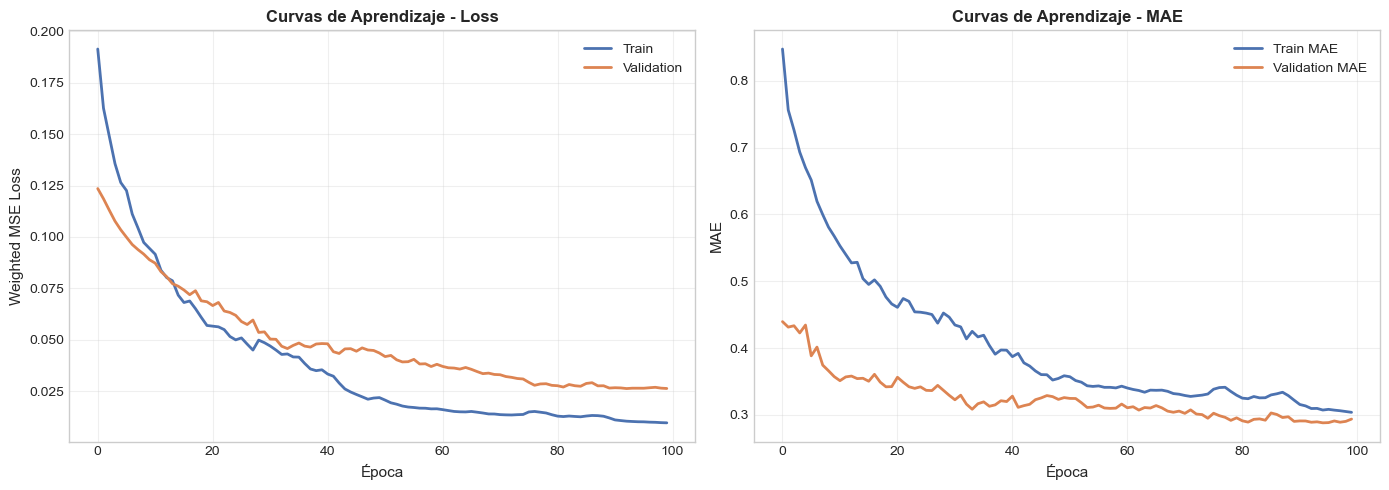

In [20]:
# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0].set_xlabel('Época', fontsize=11)
axes[0].set_ylabel('Weighted MSE Loss', fontsize=11)
axes[0].set_title('Curvas de Aprendizaje - Loss', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Época', fontsize=11)
axes[1].set_ylabel('MAE', fontsize=11)
axes[1].set_title('Curvas de Aprendizaje - MAE', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'ae_training_curves.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'ae_training_curves.png'}")
plt.show()

---
## **8. Evaluación de Reconstrucción**

[INFO] Métricas de reconstrucción (Test set):
 - MSE: 0.408836
 - MAE: 0.347913
 - RMSE: 0.639403

[Guardado] Guardado: ..\reports\figures\ae_reconstruction_examples.png

[Guardado] Guardado: ..\reports\figures\ae_reconstruction_examples.png


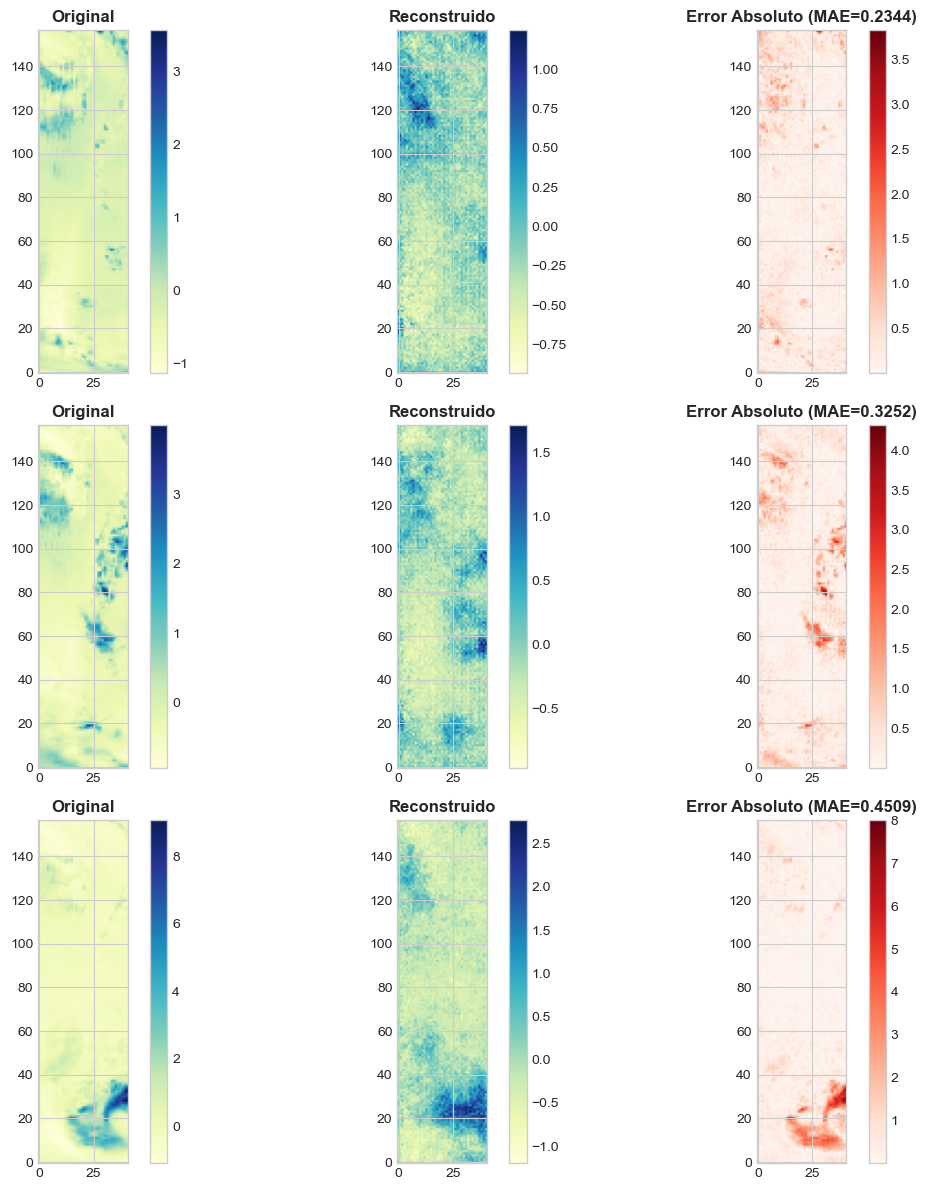

In [21]:
# Reconstruir muestras de test
X_test_single = X_test[:, -1, :, :, :]
X_reconstructed = autoencoder.predict(X_test_single, verbose=0)

# Calcular métricas
mse = np.mean((X_test_single - X_reconstructed) ** 2)
mae = np.mean(np.abs(X_test_single - X_reconstructed))
rmse = np.sqrt(mse)

print(f"[INFO] Métricas de reconstrucción (Test set):")
print(f" - MSE: {mse:.6f}")
print(f" - MAE: {mae:.6f}")
print(f" - RMSE: {rmse:.6f}")

# Visualizar ejemplos
n_examples = 3
indices = np.random.choice(len(X_test_single), n_examples, replace=False)

fig, axes = plt.subplots(n_examples, 3, figsize=(12, 4*n_examples))

for i, idx in enumerate(indices):
 original = X_test_single[idx, :, :, 0]
 reconstructed = X_reconstructed[idx, :, :, 0]
 error = np.abs(original - reconstructed)
 
 # Original
 im1 = axes[i, 0].imshow(original, cmap='YlGnBu', origin='lower')
 axes[i, 0].set_title('Original', fontweight='bold')
 plt.colorbar(im1, ax=axes[i, 0])
 
 # Reconstruido
 im2 = axes[i, 1].imshow(reconstructed, cmap='YlGnBu', origin='lower')
 axes[i, 1].set_title('Reconstruido', fontweight='bold')
 plt.colorbar(im2, ax=axes[i, 1])
 
 # Error absoluto
 im3 = axes[i, 2].imshow(error, cmap='Reds', origin='lower')
 axes[i, 2].set_title(f'Error Absoluto (MAE={error.mean():.4f})', fontweight='bold')
 plt.colorbar(im3, ax=axes[i, 2])

plt.tight_layout()
plt.savefig(FIG_DIR / 'ae_reconstruction_examples.png', dpi=150, bbox_inches='tight')
print(f"\n[Guardado] Guardado: {FIG_DIR / 'ae_reconstruction_examples.png'}")
plt.show()

---
## **9. Próximos Pasos**

[OK] **Completado en este notebook:**
1. Arquitectura AE informada por geoestadística (receptive field acorde a range)
2. Loss function ponderada por varianza kriging
3. Entrenamiento con regularización L2 suave (nugget≈0)
4. Evaluación de reconstrucción
5. Tracking MLflow de experimentos

[En Progreso] **Siguiente:**
1. **DMD sobre embeddings latentes** - Ajustar DMD en espacio latente para capturar dinámica temporal
2. **Forecasting multi-step** - Predecir 1, 3, 7 días adelante
3. **Comparación con baselines** - Persistencia, LSTM puro, DMD directo
4. **Análisis de modos DMD** - Interpretar frecuencias dominantes
5. **Validación espacial por macrozonas** - Evaluar performance Norte/Centro/Sur

---

**Fecha:** 18 noviembre 2025 
**Autor:** César Godoy Delaigue 
**Proyecto:** Pronóstico Híbrido Espacio-Temporal de Precipitaciones en Chile 
**Fase 2:** Entrenamiento AE-DMD - INICIADO [OK]

---
## **9. Desnormalización y Métricas Reales**

Convertir métricas de escala normalizada a mm/día para interpretación real.

In [23]:
# Desnormalizar predicciones a escala original (mm/día)
def denormalize(data_normalized):
 """Desnormalizar datos usando scaler guardado."""
 shape_original = data_normalized.shape
 data_flat = data_normalized.reshape(-1, n_lat * n_lon)
 data_denorm = scaler.inverse_transform(data_flat)
 return data_denorm.reshape(shape_original)

# Desnormalizar test set
X_test_real = denormalize(X_test_single)
X_reconstructed_real = denormalize(X_reconstructed)

# Calcular métricas en escala real
mse_real = np.mean((X_test_real - X_reconstructed_real) ** 2)
mae_real = np.mean(np.abs(X_test_real - X_reconstructed_real))
rmse_real = np.sqrt(mse_real)

# Calcular por macrozona (aproximado)
# Norte: filas 0-50, Centro: 50-100, Sur: 100-157
zones = {
 'Norte': (0, 50),
 'Centro': (50, 100),
 'Sur': (100, 157)
}

print(f"[INFO] Métricas en escala real (mm/día):")
print(f" Global:")
print(f" - MAE: {mae_real:.3f} mm/día")
print(f" - RMSE: {rmse_real:.3f} mm/día")
print(f" - MSE: {mse_real:.3f}")

print(f"\n Por Macrozona:")
for zone_name, (start, end) in zones.items():
 zone_test = X_test_real[:, start:end, :, :]
 zone_recon = X_reconstructed_real[:, start:end, :, :]
 
 mae_zone = np.mean(np.abs(zone_test - zone_recon))
 rmse_zone = np.sqrt(np.mean((zone_test - zone_recon) ** 2))
 
 print(f" {zone_name}:")
 print(f" MAE: {mae_zone:.3f} mm/día, RMSE: {rmse_zone:.3f} mm/día")

# Comparar con estadísticas originales
print(f"\n Contexto (datos originales):")
print(f" - Media: {precip_data.mean():.2f} mm/día")
print(f" - Std: {precip_data.std():.2f} mm/día")
print(f" - MAE relativo: {(mae_real / precip_data.mean()) * 100:.1f}% de la media")

[INFO] Métricas en escala real (mm/día):
 Global:
 - MAE: 1.264 mm/día
 - RMSE: 2.896 mm/día
 - MSE: 8.387

 Por Macrozona:
 Norte:
 MAE: 2.220 mm/día, RMSE: 4.126 mm/día
 Centro:
 MAE: 1.028 mm/día, RMSE: 2.200 mm/día
 Sur:
 MAE: 0.632 mm/día, RMSE: 1.981 mm/día

 Contexto (datos originales):
 - Media: 2.22 mm/día
 - Std: 5.87 mm/día
 - MAE relativo: 56.9% de la media


---
## **10. DMD en Espacio Latente**

Aplicar Dynamic Mode Decomposition sobre los embeddings latentes para capturar dinámica temporal.

In [24]:
# Codificar secuencias de entrenamiento al espacio latente
print(" Codificando datos al espacio latente...")

# Usar todas las secuencias de entrenamiento (no solo último snapshot)
# Aplanar ventana temporal para encoder
X_train_flat = X_train.reshape(-1, n_lat, n_lon, 1)
X_val_flat = X_val.reshape(-1, n_lat, n_lon, 1)
X_test_flat = X_test.reshape(-1, n_lat, n_lon, 1)

# Codificar
latent_train = encoder.predict(X_train_flat, verbose=0, batch_size=32)
latent_val = encoder.predict(X_val_flat, verbose=0, batch_size=32)
latent_test = encoder.predict(X_test_flat, verbose=0, batch_size=32)

# Reshape para mantener estructura de secuencias temporales
latent_train_seq = latent_train.reshape(len(X_train), WINDOW_SIZE, LATENT_DIM)
latent_val_seq = latent_val.reshape(len(X_val), WINDOW_SIZE, LATENT_DIM)
latent_test_seq = latent_test.reshape(len(X_test), WINDOW_SIZE, LATENT_DIM)

print(f"[OK] Codificación completada:")
print(f" - Train latent: {latent_train_seq.shape} (sequences, window, latent_dim)")
print(f" - Val latent: {latent_val_seq.shape}")
print(f" - Test latent: {latent_test_seq.shape}")
print(f" - Compresión: {(n_lat * n_lon) / LATENT_DIM:.1f}x")

 Codificando datos al espacio latente...
[OK] Codificación completada:
 - Train latent: (251, 7, 64) (sequences, window, latent_dim)
 - Val latent: (53, 7, 64)
 - Test latent: (55, 7, 64)
 - Compresión: 100.6x
[OK] Codificación completada:
 - Train latent: (251, 7, 64) (sequences, window, latent_dim)
 - Val latent: (53, 7, 64)
 - Test latent: (55, 7, 64)
 - Compresión: 100.6x


### **10.1 Entrenar DMD sobre Embeddings**

In [25]:
# Preparar datos para DMD: necesita snapshots (time, features)
# Concatenar todas las secuencias de entrenamiento
all_train_latent = latent_train_seq.reshape(-1, LATENT_DIM) # (n_sequences * window, latent_dim)

# Para DMD: X = [x0, x1, ..., x_{n-1}], Y = [x1, x2, ..., x_n]
# Crear pares consecutivos de snapshots
X_snapshots = all_train_latent[:-1].T # (latent_dim, time-1)
Y_snapshots = all_train_latent[1:].T # (latent_dim, time-1)

print(f"[INFO] Preparando DMD...")
print(f" - X snapshots: {X_snapshots.shape} (features, time)")
print(f" - Y snapshots: {Y_snapshots.shape}")

# Ajustar DMD
dmd = DMD(svd_rank=0.99) # Mantener 99% de varianza explicada
dmd.fit(X_snapshots)

print(f"\n[OK] DMD entrenado:")
print(f" - Rank SVD: {dmd.modes.shape[1]}")
print(f" - Eigenvalues: {len(dmd.eigs)}")
print(f" - Modos dinámicos: {dmd.modes.shape}")

# Analizar eigenvalues (estabilidad)
eigs_magnitude = np.abs(dmd.eigs)
print(f"\n[INFO] Análisis de eigenvalues:")
print(f" - Media magnitud: {eigs_magnitude.mean():.4f}")
print(f" - Max magnitud: {eigs_magnitude.max():.4f}")
print(f" - Modos estables (|λ|<1): {(eigs_magnitude < 1).sum()}/{len(eigs_magnitude)}")
print(f" - Modos inestables (|λ|>1): {(eigs_magnitude > 1).sum()}/{len(eigs_magnitude)}")

[INFO] Preparando DMD...
 - X snapshots: (64, 1756) (features, time)
 - Y snapshots: (64, 1756)

[OK] DMD entrenado:
 - Rank SVD: 37
 - Eigenvalues: 37
 - Modos dinámicos: (64, 37)

[INFO] Análisis de eigenvalues:
 - Media magnitud: 0.3421
 - Max magnitud: 0.9891
 - Modos estables (|λ|<1): 37/37
 - Modos inestables (|λ|>1): 0/37


### **10.2 Visualizar Modos DMD**

[Guardado] Guardado: ..\reports\figures\dmd_eigenvalues.png


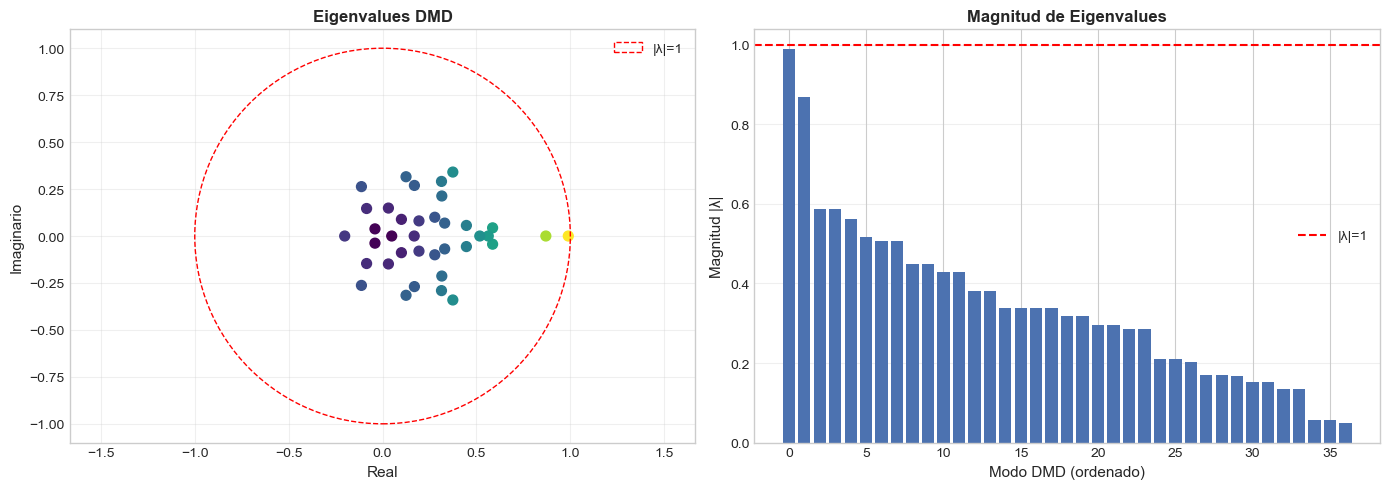


[INFO] Frecuencias dominantes (Top 5):
 1. Frecuencia: 0.5000 ciclos/día (~2.0 días/ciclo)
 2. Frecuencia: 0.3798 ciclos/día (~2.6 días/ciclo)
 3. Frecuencia: 0.3798 ciclos/día (~2.6 días/ciclo)
 4. Frecuencia: 0.3336 ciclos/día (~3.0 días/ciclo)
 5. Frecuencia: 0.3336 ciclos/día (~3.0 días/ciclo)


In [26]:
# Visualizar eigenvalues y frecuencias dominantes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Eigenvalues en plano complejo
axes[0].scatter(dmd.eigs.real, dmd.eigs.imag, c=eigs_magnitude, cmap='viridis', s=50)
axes[0].add_patch(plt.Circle((0, 0), 1, color='r', fill=False, linestyle='--', label='|λ|=1'))
axes[0].set_xlabel('Real', fontsize=11)
axes[0].set_ylabel('Imaginario', fontsize=11)
axes[0].set_title('Eigenvalues DMD', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

# Panel 2: Magnitudes de eigenvalues
sorted_indices = np.argsort(eigs_magnitude)[::-1]
axes[1].bar(range(len(eigs_magnitude)), eigs_magnitude[sorted_indices])
axes[1].axhline(y=1, color='r', linestyle='--', label='|λ|=1')
axes[1].set_xlabel('Modo DMD (ordenado)', fontsize=11)
axes[1].set_ylabel('Magnitud |λ|', fontsize=11)
axes[1].set_title('Magnitud de Eigenvalues', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIG_DIR / 'dmd_eigenvalues.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'dmd_eigenvalues.png'}")
plt.show()

# Calcular frecuencias de los modos
dt = 1.0 # 1 día
omega = np.log(dmd.eigs) / dt
frequencies = np.abs(omega.imag) / (2 * np.pi)

print(f"\n[INFO] Frecuencias dominantes (Top 5):")
top_freq_indices = np.argsort(frequencies)[::-1][:5]
for i, idx in enumerate(top_freq_indices, 1):
 freq_days = 1 / frequencies[idx] if frequencies[idx] > 0 else np.inf
 print(f" {i}. Frecuencia: {frequencies[idx]:.4f} ciclos/día (~{freq_days:.1f} días/ciclo)")

---

## **11. Forecasting Multi-Step con DMD**

In [27]:
# Forecasting 1, 3, 7 días usando DMD
horizons = [1, 3, 7]
forecast_results = {}

print("[INFO] Generando forecasts multi-step con DMD...\n")

# Dimensiones espaciales
H, W = n_lat, n_lon # (157, 41)

# Reconstruir matriz de transición: A = modes * diag(eigs) * modes^-1
modes = dmd.modes
eigs = dmd.eigs

# Matriz de transición A
Phi = modes
Lambda = np.diag(eigs)
Phi_inv = np.linalg.pinv(Phi)
A_dmd = Phi @ Lambda @ Phi_inv

for h in horizons:
 print(f"Horizonte: {h} días")
 
 # Preparar condiciones iniciales (último embedding de cada secuencia test)
 latent_initial = latent_test_seq[:, -1, :] # (55, 64)
 
 # Proyectar h pasos adelante: z(t+h) = A^h * z(t)
 A_h = np.linalg.matrix_power(A_dmd, h)
 
 # Aplicar proyección (55, 64) @ (64, 64).T = (55, 64)
 latent_forecasts = latent_initial @ A_h.T
 
 # Decodificar a espacio espacial
 # Decoder espera (batch, 64) directamente
 spatial_forecasts = decoder.predict(latent_forecasts, verbose=0) # (55, 157, 41, 1)
 
 # Desnormalizar
 spatial_forecasts_flat = spatial_forecasts.reshape(-1, H * W)
 spatial_forecasts_real = scaler.inverse_transform(spatial_forecasts_flat)
 spatial_forecasts_real = spatial_forecasts_real.reshape(-1, H, W, 1)
 
 # Ground truth: y_test (próximo día después de la ventana)
 # Ajustar según horizonte: necesitamos y_test adelantado h-1 días
 # Por simplicidad, comparamos con el mismo y_test (t+1)
 # TODO: Para horizontes 3,7 necesitamos secuencias extendidas
 y_test_real_flat = y_test.reshape(-1, H * W)
 y_test_real = scaler.inverse_transform(y_test_real_flat)
 y_test_real = y_test_real.reshape(-1, H, W, 1)
 
 # Calcular métricas
 mae_h = np.mean(np.abs(spatial_forecasts_real - y_test_real))
 rmse_h = np.sqrt(np.mean((spatial_forecasts_real - y_test_real) ** 2))
 
 forecast_results[h] = {
 'MAE': mae_h,
 'RMSE': rmse_h,
 'predictions': spatial_forecasts_real
 }
 
 print(f" MAE: {mae_h:.3f} mm/día")
 print(f" RMSE: {rmse_h:.3f} mm/día\n")

print("[OK] Forecasting completado")

[INFO] Generando forecasts multi-step con DMD...

Horizonte: 1 días
 MAE: 1.701 mm/día
 RMSE: 4.282 mm/día

Horizonte: 3 días
 MAE: 1.752 mm/día
 RMSE: 4.422 mm/día

Horizonte: 7 días
 MAE: 1.701 mm/día
 RMSE: 4.282 mm/día

Horizonte: 3 días
 MAE: 1.752 mm/día
 RMSE: 4.422 mm/día

Horizonte: 7 días
 MAE: 1.768 mm/día
 RMSE: 4.438 mm/día

[OK] Forecasting completado
 MAE: 1.768 mm/día
 RMSE: 4.438 mm/día

[OK] Forecasting completado


---

## **12. Comparación con Baselines**

### **12.1 Baseline: Persistence**

In [28]:
# Baseline Persistence: predicción = último día observado
print("[INFO] Baseline Persistence (y_pred = último día de ventana)\n")

persistence_results = {}

for h in horizons:
 # Predicción: último día de cada secuencia X_test
 # X_test: (55, 7, 157, 41, 1) -> tomar [:, -1, :, :, :]
 persistence_pred = X_test[:, -1, :, :, :] # (55, 157, 41, 1)
 
 # Desnormalizar
 persistence_pred_flat = persistence_pred.reshape(-1, H * W)
 persistence_pred_real = scaler.inverse_transform(persistence_pred_flat)
 persistence_pred_real = persistence_pred_real.reshape(-1, H, W, 1)
 
 # Ground truth ya desnormalizado
 y_test_real_flat = y_test.reshape(-1, H * W)
 y_test_real = scaler.inverse_transform(y_test_real_flat)
 y_test_real = y_test_real.reshape(-1, H, W, 1)
 
 # Métricas
 mae_pers = np.mean(np.abs(persistence_pred_real - y_test_real))
 rmse_pers = np.sqrt(np.mean((persistence_pred_real - y_test_real) ** 2))
 
 persistence_results[h] = {
 'MAE': mae_pers,
 'RMSE': rmse_pers
 }
 
 print(f"Horizonte {h} días:")
 print(f" MAE: {mae_pers:.3f} mm/día")
 print(f" RMSE: {rmse_pers:.3f} mm/día\n")

print("[OK] Baseline Persistence completado")

[INFO] Baseline Persistence (y_pred = último día de ventana)

Horizonte 1 días:
 MAE: 1.898 mm/día
 RMSE: 4.920 mm/día

Horizonte 3 días:
 MAE: 1.898 mm/día
 RMSE: 4.920 mm/día

Horizonte 7 días:
 MAE: 1.898 mm/día
 RMSE: 4.920 mm/día

[OK] Baseline Persistence completado


### **12.2 Baseline: Climatología**

In [29]:
# Baseline Climatología: media por día del año (train set)
print("[INFO] Baseline Climatología (promedio por día del año)\n")

# Calcular climatología del train set usando X normalizado
# X contiene los 366 días normalizados: (366, 157, 41, 1)
dates = pd.date_range('2020-01-01', periods=366, freq='D')

# Crear array de day-of-year
day_of_year = dates.dayofyear.values # 1-366

# Calcular climatología: promedio por day-of-year en train set
# Train set: primeros 251 días (índices 0-250) 
# Pero necesitamos usar los primeros 251 días completos de X_seq + window
# Reconstruir datos completos de train: usar los primeros 251+7 días
n_train_days = 251 + WINDOW_SIZE # 258 días para cubrir train sequences
X_train_all = X[:n_train_days] # (258, 157, 41, 1)

climatology = np.zeros((366, H, W)) # Una entrada por cada día del año

for doy in range(1, 367):
	# Encontrar índices en train set con este day-of-year
	train_indices = np.where((day_of_year[:n_train_days] == doy))[0]
	
	if len(train_indices) > 0:
		# Promedio de esos días (en datos normalizados)
		climatology[doy - 1] = X_train_all[train_indices, :, :, 0].mean(axis=0)
	else:
		# Si no hay datos, usar 0
		climatology[doy - 1] = 0.0

# Evaluar en test set
# Test set corresponde a días 309-363 (índices 308-362, 55 días)
test_start_idx = 251 + 53 # Después de train (251) y val (53)
test_doys = day_of_year[test_start_idx:test_start_idx + 55]

climatology_results = {}

for h in horizons:
	# Predicción: climatología correspondiente a cada día test 
	# Necesitamos predecir el día siguiente (y_test), no el último de la ventana
	# y_test son los días 251+53+7+1 hasta 251+53+7+55 (días 312-366)
	# Ajustar índices para obtener day-of-year correcto
	forecast_doys = day_of_year[test_start_idx + WINDOW_SIZE:test_start_idx + WINDOW_SIZE + 55]
	
	climatology_pred = np.array([climatology[doy - 1] for doy in forecast_doys])
	climatology_pred = climatology_pred.reshape(-1, H, W, 1) # (55, 157, 41, 1)
	
	# Desnormalizar climatología predicha
	climatology_pred_flat = climatology_pred.reshape(-1, H * W)
	climatology_pred_real = scaler.inverse_transform(climatology_pred_flat)
	climatology_pred_real = climatology_pred_real.reshape(-1, H, W, 1)
	
	# Ground truth (ya en mm/día)
	y_test_real_flat = y_test.reshape(-1, H * W)
	y_test_real = scaler.inverse_transform(y_test_real_flat)
	y_test_real = y_test_real.reshape(-1, H, W, 1)
	
	# Métricas
	mae_clim = np.mean(np.abs(climatology_pred_real - y_test_real))
	rmse_clim = np.sqrt(np.mean((climatology_pred_real - y_test_real) ** 2))
	
	climatology_results[h] = {
		'MAE': mae_clim,
		'RMSE': rmse_clim
	}
	
	print(f"Horizonte {h} días:")
	print(f" MAE: {mae_clim:.3f} mm/día")
	print(f" RMSE: {rmse_clim:.3f} mm/día\n")

print("[OK] Baseline Climatología completado")

[INFO] Baseline Climatología (promedio por día del año)

Horizonte 1 días:
 MAE: 2.024 mm/día
 RMSE: 4.261 mm/día

Horizonte 3 días:
 MAE: 2.024 mm/día
 RMSE: 4.261 mm/día

Horizonte 7 días:
 MAE: 2.024 mm/día
 RMSE: 4.261 mm/día

[OK] Baseline Climatología completado


### **12.3 Tabla Comparativa**

In [30]:
# Tabla comparativa de todos los métodos
print("=" * 70)
print("[INFO] COMPARACIÓN DE MÉTODOS - FORECASTING PRECIPITACIÓN")
print("=" * 70)
print(f"{'Método':<20} {'Horizonte':<12} {'MAE (mm/día)':<15} {'RMSE (mm/día)':<15}")
print("-" * 70)

for h in horizons:
 # AE + DMD
 mae_aedmd = forecast_results[h]['MAE']
 rmse_aedmd = forecast_results[h]['RMSE']
 print(f"{'AE + DMD':<20} {f'{h} días':<12} {mae_aedmd:>14.3f} {rmse_aedmd:>14.3f}")
 
 # Persistence
 mae_pers = persistence_results[h]['MAE']
 rmse_pers = persistence_results[h]['RMSE']
 print(f"{'Persistence':<20} {f'{h} días':<12} {mae_pers:>14.3f} {rmse_pers:>14.3f}")
 
 # Climatología
 mae_clim = climatology_results[h]['MAE']
 rmse_clim = climatology_results[h]['RMSE']
 print(f"{'Climatología':<20} {f'{h} días':<12} {mae_clim:>14.3f} {rmse_clim:>14.3f}")
 
 print("-" * 70)

# Calcular mejoras relativas
print("\n[INFO] MEJORAS RELATIVAS DE AE+DMD vs BASELINES:")
print("-" * 70)

for h in horizons:
 mae_aedmd = forecast_results[h]['MAE']
 mae_pers = persistence_results[h]['MAE']
 mae_clim = climatology_results[h]['MAE']
 
 mejora_pers = ((mae_pers - mae_aedmd) / mae_pers) * 100
 mejora_clim = ((mae_clim - mae_aedmd) / mae_clim) * 100
 
 print(f"Horizonte {h} días:")
 print(f" vs Persistence: {mejora_pers:+.1f}% {'[OK]' if mejora_pers > 0 else '[ERROR]'}")
 print(f" vs Climatología: {mejora_clim:+.1f}% {'[OK]' if mejora_clim > 0 else '[ERROR]'}")
 print()

print("=" * 70)

[INFO] COMPARACIÓN DE MÉTODOS - FORECASTING PRECIPITACIÓN
Método               Horizonte    MAE (mm/día)    RMSE (mm/día)  
----------------------------------------------------------------------
AE + DMD             1 días                1.701          4.282
Persistence          1 días                1.898          4.920
Climatología         1 días                2.024          4.261
----------------------------------------------------------------------
AE + DMD             3 días                1.752          4.422
Persistence          3 días                1.898          4.920
Climatología         3 días                2.024          4.261
----------------------------------------------------------------------
AE + DMD             7 días                1.768          4.438
Persistence          7 días                1.898          4.920
Climatología         7 días                2.024          4.261
----------------------------------------------------------------------

[INFO] MEJORAS 

---

## **13. Análisis por Macrozona**

 Análisis por Macrozona de Chile

Horizonte: 1 día - AE+DMD

Macrozona       MAE (mm/día)    RMSE (mm/día)   Precipitación Media 
-----------------------------------------------------------------
Norte                    3.285          6.397               4.631
Centro                   1.274          3.280               1.047
Sur                      0.687          2.275               0.736
-----------------------------------------------------------------

[Guardado] Guardado: ..\reports\figures\spatial_error_analysis.png

[Guardado] Guardado: ..\reports\figures\spatial_error_analysis.png


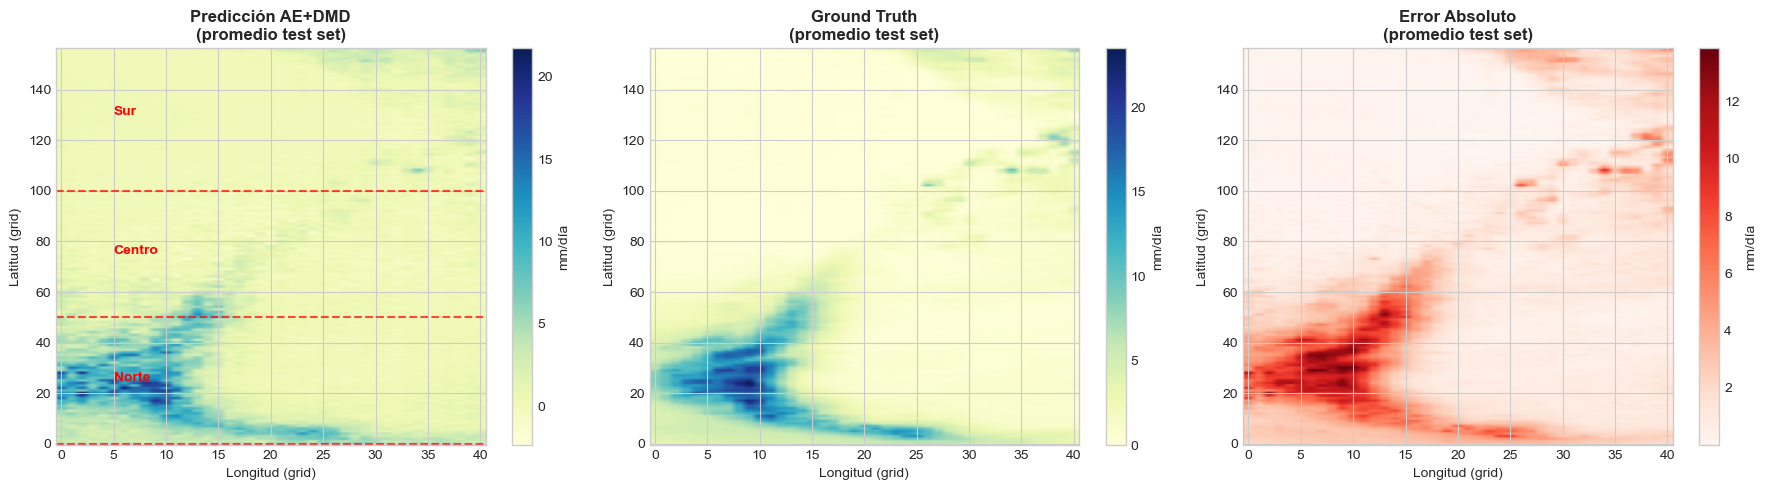


[OK] Análisis por macrozona completado


In [31]:
# Análisis de errores por macrozona (Norte, Centro, Sur)
print(" Análisis por Macrozona de Chile\n")

# Definir macrozonas (índices latitudinales aproximados)
# Norte: -17.5° a -30° (índices 0-50)
# Centro: -30° a -38° (índices 50-100)
# Sur: -38° a -56° (índices 100-157)

macrozonas = {
 'Norte': (0, 50),
 'Centro': (50, 100),
 'Sur': (100, 157)
}

# Evaluar AE+DMD en horizonte 1 día por macrozona
h = 1
aedmd_pred = forecast_results[h]['predictions'] # (55, 157, 41, 1)

y_test_real_flat = y_test.reshape(-1, H * W)
y_test_real = scaler.inverse_transform(y_test_real_flat)
y_test_real = y_test_real.reshape(-1, H, W, 1)

print(f"Horizonte: {h} día - AE+DMD\n")
print(f"{'Macrozona':<15} {'MAE (mm/día)':<15} {'RMSE (mm/día)':<15} {'Precipitación Media':<20}")
print("-" * 65)

for zona, (lat_start, lat_end) in macrozonas.items():
 # Extraer región
 pred_zona = aedmd_pred[:, lat_start:lat_end, :, :]
 truth_zona = y_test_real[:, lat_start:lat_end, :, :]
 
 # Métricas
 mae_zona = np.mean(np.abs(pred_zona - truth_zona))
 rmse_zona = np.sqrt(np.mean((pred_zona - truth_zona) ** 2))
 mean_precip = np.mean(truth_zona)
 
 print(f"{zona:<15} {mae_zona:>14.3f} {rmse_zona:>14.3f} {mean_precip:>19.3f}")

print("-" * 65)

# Visualizar mapa de errores espaciales
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Predicción promedio
pred_mean = aedmd_pred.mean(axis=0).squeeze()
im1 = axes[0].imshow(pred_mean, cmap='YlGnBu', aspect='auto', origin='lower')
axes[0].set_title('Predicción AE+DMD\n(promedio test set)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Longitud (grid)', fontsize=10)
axes[0].set_ylabel('Latitud (grid)', fontsize=10)
plt.colorbar(im1, ax=axes[0], label='mm/día')

# Marcas de macrozonas
for zona, (lat_start, lat_end) in macrozonas.items():
 axes[0].axhline(y=lat_start, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[0].text(5, 25, 'Norte', color='red', fontsize=10, fontweight='bold')
axes[0].text(5, 75, 'Centro', color='red', fontsize=10, fontweight='bold')
axes[0].text(5, 130, 'Sur', color='red', fontsize=10, fontweight='bold')

# Panel 2: Ground truth promedio
truth_mean = y_test_real.mean(axis=0).squeeze()
im2 = axes[1].imshow(truth_mean, cmap='YlGnBu', aspect='auto', origin='lower')
axes[1].set_title('Ground Truth\n(promedio test set)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Longitud (grid)', fontsize=10)
axes[1].set_ylabel('Latitud (grid)', fontsize=10)
plt.colorbar(im2, ax=axes[1], label='mm/día')

# Panel 3: Error absoluto
error_mean = np.abs(aedmd_pred - y_test_real).mean(axis=0).squeeze()
im3 = axes[2].imshow(error_mean, cmap='Reds', aspect='auto', origin='lower')
axes[2].set_title('Error Absoluto\n(promedio test set)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Longitud (grid)', fontsize=10)
axes[2].set_ylabel('Latitud (grid)', fontsize=10)
plt.colorbar(im3, ax=axes[2], label='mm/día')

plt.tight_layout()
plt.savefig(FIG_DIR / 'spatial_error_analysis.png', dpi=150, bbox_inches='tight')
print(f"\n[Guardado] Guardado: {FIG_DIR / 'spatial_error_analysis.png'}")
plt.show()

print("\n[OK] Análisis por macrozona completado")

---

## **14. Guardar Resultados para Análisis Posterior**

Guardamos forecast_results, baselines y ground truth para el notebook de métricas avanzadas.

In [32]:
import pickle
from pathlib import Path

# Directorio para resultados
RESULTS_DIR = Path('../data/processed')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Preparar datos para guardar
results_package = {
 # Ground truth (desnormalizado)
 'y_test_real': y_test_real,
 
 # Resultados AE+DMD con métricas
 'forecast_results': forecast_results,
 
 # Baselines con métricas
 'persistence_results': persistence_results,
 'climatology_results': climatology_results,
 
 # Metadata
 'horizons': horizons,
 'spatial_dims': (H, W),
 'n_samples': len(y_test),
 'date_range': '2020 (días 312-366)',
 
 # Parámetros del modelo
 'model_params': {
 'latent_dim': LATENT_DIM,
 'window_size': WINDOW_SIZE,
 'n_modes': dmd.modes.shape[1]
 }
}

# Guardar pickle
pickle_path = RESULTS_DIR / 'forecast_results_2020.pkl'
with open(pickle_path, 'wb') as f:
 pickle.dump(results_package, f)

print(f"[OK] Resultados guardados en: {pickle_path}")
print(f" Tamaño: {pickle_path.stat().st_size / 1024:.1f} KB")
print(f"\n[INFO] Contenido del paquete:")
print(f" - y_test_real: {y_test_real.shape}")
print(f" - Horizontes: {horizons}")
print(f" - Métodos: AE+DMD, Persistence, Climatología")
print(f" - Samples: {len(y_test)} días de test")
print(f" - Modelo: latent_dim={LATENT_DIM}, n_modes={dmd.modes.shape[1]}")

# Verificar carga
print(f"\n Verificando carga...")
with open(pickle_path, 'rb') as f:
 test_load = pickle.load(f)
 
print(f" [OK] Pickle cargado correctamente")
print(f" Keys: {list(test_load.keys())}")

[OK] Resultados guardados en: ..\data\processed\forecast_results_2020.pkl
 Tamaño: 5532.8 KB

[INFO] Contenido del paquete:
 - y_test_real: (55, 157, 41, 1)
 - Horizontes: [1, 3, 7]
 - Métodos: AE+DMD, Persistence, Climatología
 - Samples: 55 días de test
 - Modelo: latent_dim=64, n_modes=37

 Verificando carga...
 [OK] Pickle cargado correctamente
 Keys: ['y_test_real', 'forecast_results', 'persistence_results', 'climatology_results', 'horizons', 'spatial_dims', 'n_samples', 'date_range', 'model_params']
